In [1]:
import PyPlot; const plt = PyPlot
using ProgressMeter
using FileIO
using Logging
include("../src/DQMC.jl")
include("../src/KinecticReader.jl")
import Statistics

const dtype = ComplexF64

function SsqureObs(x::DQMCWalker, scheme)
    sum = 0
    for i in 1:scheme.Nsite
        sum += 2*(1 - x.glTemp[i, i]) * x.glTemp[i, i]
    end
    return 0.75 * sum / scheme.Nsite
end

SsqureObs (generic function with 1 method)

In [2]:
debuglogger = ConsoleLogger(stderr, Logging.Info)
global_logger(debuglogger)

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(45) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

In [5]:
function ringS2QMC(beta, U, deltaTau, thermalizationTime, iterationTime, refreshInterval)
    nx = 6
    ny = 1
    Δτ = deltaTau
    β = beta
    nflavor = 2

    # M, lattice length in imaginary time direction
    p = Progress(thermalizationTime + iterationTime, 2)
    M = Int((β+0.01) ÷ Δτ)
    println(M)

    Nsites, Kinectic = BuildKinecticFromYAML("../src/hams/1dRingHamiltonian.yml", nx, ny, dtype)
    schemeSU2N = DQMCScheme{dtype}(Nsites, nflavor, M, Δτ, Kinectic)
    paramsAux = AuxFieldUpdaterParams{dtype}(U, schemeSU2N)
    x = initializeWalker(schemeSU2N, paramsAux, refreshInterval);

    for i in 1:thermalizationTime
        walkerMarkovMove!(x, paramsAux, schemeSU2N)
        next!(p)
    end

    s2 = Vector{dtype}(undef, iterationTime)

    for i in 1:iterationTime
        walkerMarkovMove!(x, paramsAux, schemeSU2N)
        s2[i] = SsqureObs(x, schemeSU2N)
        next!(p)
    end

    s2
end

ringS2QMC (generic function with 1 method)

In [10]:
tau = 0.125
betas = [2, 3, 4, 5, 6, 7, 8, 12, 16, 32, 60] * tau
s2_list = []
s2_std_list = []
for beta in betas
    s2 = ringS2QMC(beta, 4.0, tau, 2000, 10000, 20)
    append!(s2_list, Statistics.mean(real.(s2)))
    append!(s2_std_list, Statistics.std(real.(s2)) / sqrt(length(s2)))
end

2
3
4


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


5


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


6


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


8


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


12


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


16


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


32


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


60


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


In [11]:
x = Dict("beta"=>betas, "sSquare_mean"=>s2_list, "sSquare_std"=>s2_std_list)
save("../data/6siteRing_spin2_U=4.0_dtau=0.125.jld2", x)

In [12]:
y = load("../data/6siteRing_spin2_U=4.0_ED.jld2")

Dict{String, Any} with 2 entries:
  "sSquare_mean" => Any[0.58347, 0.586659, 0.59357, 0.598725, 0.600817, 0.60041…
  "beta"         => [10.0, 5.0, 3.33333, 2.5, 2.0, 1.66667, 1.42857, 1.25, 1.11…

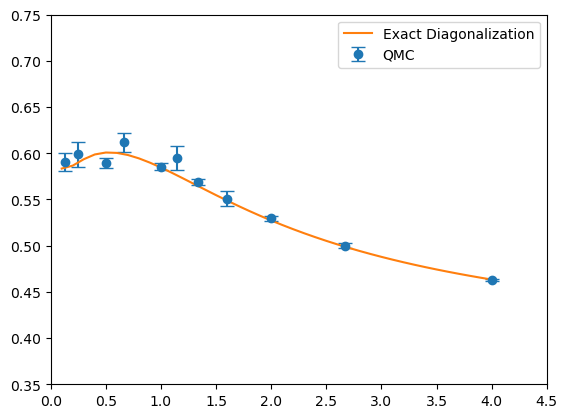

In [13]:
plt.errorbar(1.0 ./ x["beta"], x["sSquare_mean"], yerr=x["sSquare_std"], ls="none", marker="o", capsize=5, label="QMC")
plt.plot(1.0 ./ y["beta"], y["sSquare_mean"], label="Exact Diagonalization")
plt.ylim((0.35,0.75))
plt.xlim((0.0, 4.5))
plt.legend()
plt.show()